In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from data_scraping.db_utils import get_connection
from IPython.display import display

In [24]:
conn = get_connection()
cards_df = pd.read_sql("SELECT * FROM cards", conn)
market_df = pd.read_sql("SELECT * FROM price_history", conn)

C:\Users\shane\AppData\Local\Temp\ipykernel_39964\4255713798.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cards_df = pd.read_sql("SELECT * FROM cards", conn)
C:\Users\shane\AppData\Local\Temp\ipykernel_39964\4255713798.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  market_df = pd.read_sql("SELECT * FROM price_history", conn)


In [25]:
# market_df = market_df.replace(0, np.nan)
market_df['date_time'] = pd.to_datetime(market_df['date_time'])
full_df = market_df.merge(cards_df, on='card_id', how='left')

print(full_df)

        card_id  pc_value  console_value           date_time          name  \
0         32880       0.0            NaN 2024-09-20 09:30:00  Khadija Shaw   
1         32880       0.0            NaN 2024-09-21 09:30:00  Khadija Shaw   
2         32880       0.0            NaN 2024-09-22 09:30:00  Khadija Shaw   
3         32880    5984.0            NaN 2024-09-23 09:30:00  Khadija Shaw   
4         32880    5800.0            NaN 2024-09-24 09:30:00  Khadija Shaw   
...         ...       ...            ...                 ...           ...   
643057    54245       NaN          744.0 2025-09-12 09:30:00  Saki Kumagai   
643058    54245       NaN            0.0 2025-09-13 09:30:00  Saki Kumagai   
643059    54245       NaN            0.0 2025-09-14 09:30:00  Saki Kumagai   
643060    54245       NaN            0.0 2025-09-15 09:30:00  Saki Kumagai   
643061    54245       NaN            0.0 2025-09-16 09:30:00  Saki Kumagai   

        game    version nationality              league        

TEST: Locatelli vs Caicedo Price Overtime EA FC 25

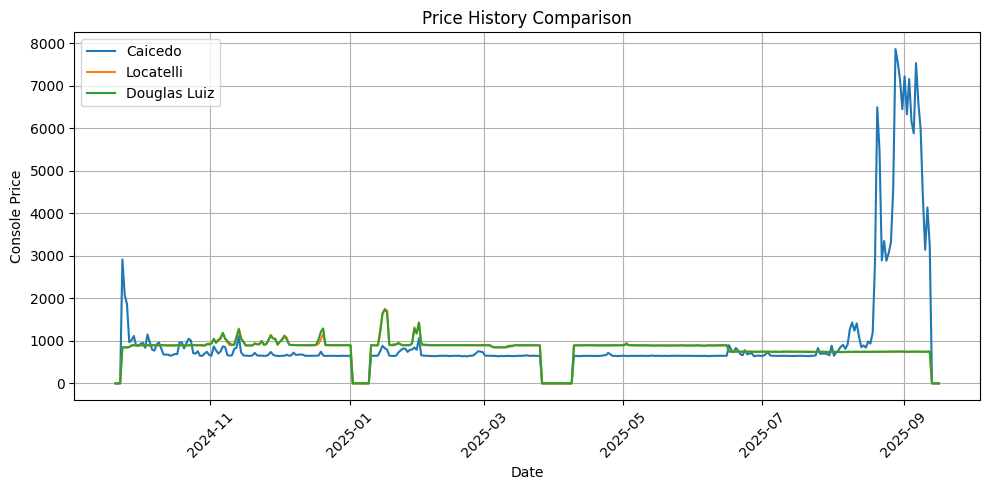

In [26]:
caicedo_price = market_df[market_df["card_id"] == 33289].copy()
locatelli_price = market_df[market_df["card_id"] == 44784].copy()
douglas_luiz_price = market_df[market_df["card_id"] == 33139].copy()

plt.figure(figsize=(10,5))
plt.plot(caicedo_price["date_time"], caicedo_price["console_value"], label="Caicedo")
plt.plot(locatelli_price["date_time"], locatelli_price["console_value"], label="Locatelli")
plt.plot(douglas_luiz_price["date_time"], douglas_luiz_price["console_value"], label="Douglas Luiz")

# plt.axhline(0, color='none')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Console Price")
plt.title("Price History Comparison")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


GOLD RARE Market History

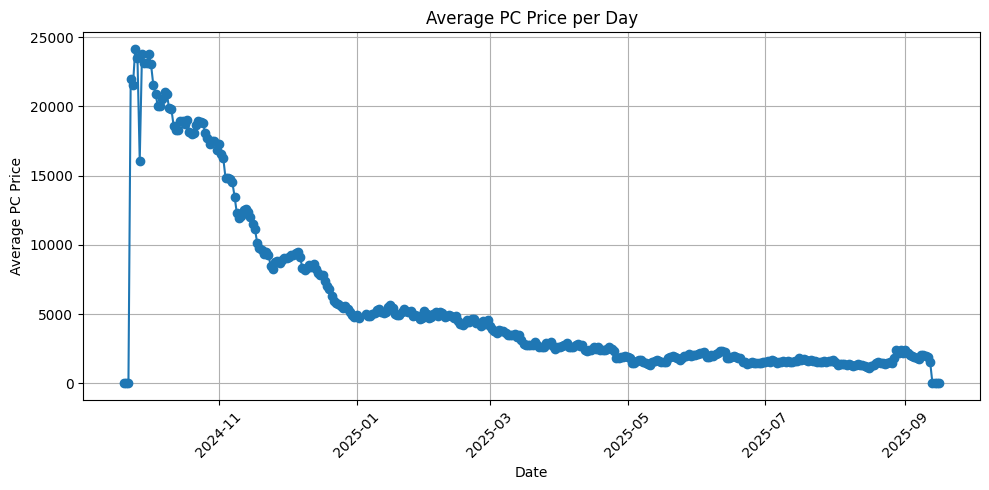

In [27]:
# Group by date only (year-month-day) and compute average
avg_prices_df = market_df.groupby(market_df['date_time'].dt.date)['pc_value'].mean().reset_index()

# Rename columns for clarity
avg_prices_df.rename(columns={'date_time': 'date', 'pc_value': 'avg_pc_value'}, inplace=True)

# Plot
plt.figure(figsize=(10,5))
plt.plot(avg_prices_df['date'], avg_prices_df['avg_pc_value'], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Average PC Price")
plt.title("Average PC Price per Day")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

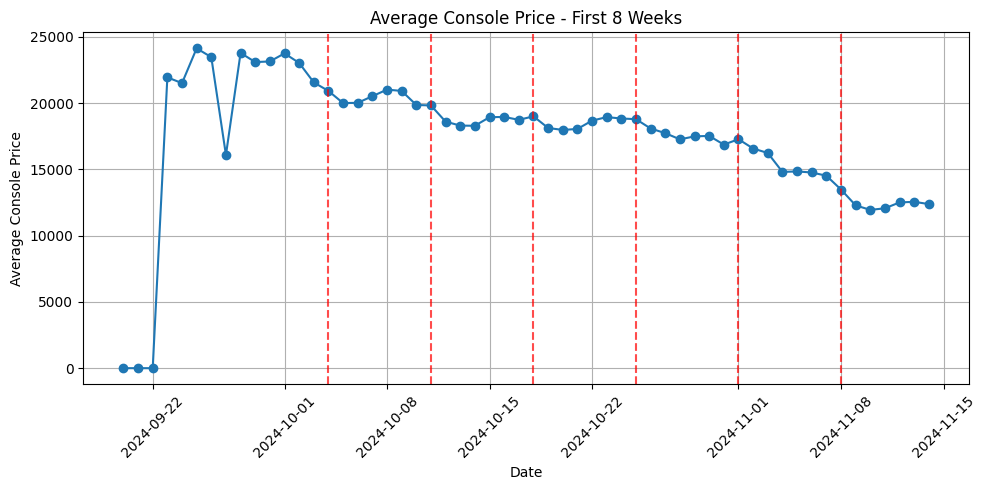

In [28]:
# Find the earliest date
start_date = market_df['date_time'].min()


n = 8

# Calculate the end date (first n weeks)
end_date = start_date + pd.Timedelta(weeks=n)

# Filter for the first n weeks
first_n_weeks_df = market_df[(market_df['date_time'] >= start_date) & (market_df['date_time'] < end_date)]

# Group by date and compute average console price
avg_prices_df = first_n_weeks_df.groupby(first_n_weeks_df['date_time'].dt.date)['pc_value'].mean().reset_index()
avg_prices_df.rename(columns={'date_time': 'date', 'pc_value': 'avg_pc_value'}, inplace=True)

# Plot
plt.figure(figsize=(10,5))
plt.plot(avg_prices_df['date'], avg_prices_df['avg_pc_value'], marker='o', linestyle='-')

# Highlight October 4th and every week after
highlight_start = pd.to_datetime('2024-10-04').date()
highlight_dates = [highlight_start + pd.Timedelta(weeks=i) for i in range(0, n-2)]  # first 3 weeks
for hd in highlight_dates:
    plt.axvline(hd, color='red', linestyle='--', alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Average Console Price")
plt.title(f"Average Console Price - First {n} Weeks")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
market_df['date_time'] = pd.to_datetime(market_df['date_time'])
print(market_df['date_time'].head())

0   2024-09-20 09:30:00
1   2024-09-21 09:30:00
2   2024-09-22 09:30:00
3   2024-09-23 09:30:00
4   2024-09-24 09:30:00
Name: date_time, dtype: datetime64[ns]


Players That Went Up The Most Each Weekend League

In [30]:
# Convert datetime if not already
market_df['date_time'] = pd.to_datetime(market_df['date_time'])
market_df['console_value'] = market_df['console_value'] * 0.95
# Aggregate to daily average per card
daily_avg = market_df.groupby(['card_id', 'date_time'], as_index=False)['console_value'].mean()

# Compute daily change per card
daily_avg['price_change'] = daily_avg.groupby('card_id')['console_value'].diff()

# Filter for a specific day (e.g., Fridays) or a recurring day like October 4th
highlight_days = daily_avg[daily_avg['date_time'].dt.weekday == 4]  # Fridays
highlight_days = highlight_days.dropna(subset=['price_change'])
# Top 3 movers per day
top_movers = highlight_days.groupby('date_time').apply(lambda x: x.nlargest(5, 'price_change')).reset_index(drop=True)


# Now display your DataFrame
print(top_movers[['date_time', 'card_id', 'price_change']])





              date_time  card_id  price_change
0   2024-09-27 09:30:00       53      46518.65
1   2024-09-27 09:30:00    43977      19484.50
2   2024-09-27 09:30:00    32949      14346.90
3   2024-09-27 09:30:00    54701      13410.20
4   2024-09-27 09:30:00       58      11131.15
..                  ...      ...           ...
245 2025-09-12 09:30:00    33239      47500.00
246 2025-09-12 09:30:00    38788       9310.00
247 2025-09-12 09:30:00    42657       8835.00
248 2025-09-12 09:30:00    33346       7695.00
249 2025-09-12 09:30:00       48       6661.40

[250 rows x 3 columns]


C:\Users\shane\AppData\Local\Temp\ipykernel_39964\3383426020.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_movers = highlight_days.groupby('date_time').apply(lambda x: x.nlargest(5, 'price_change')).reset_index(drop=True)


Players That Went Down The Most Each Weekend League

In [31]:
# Get top 3 decreases per date
top_decrease = highlight_days.groupby('date_time').apply(
    lambda x: x.nsmallest(5, 'price_change')
).reset_index(drop=True)

# Print
print(top_decrease[['date_time', 'card_id', 'price_change']])

              date_time  card_id  price_change
0   2024-09-27 09:30:00       37     -72999.90
1   2024-09-27 09:30:00    32860     -12943.75
2   2024-09-27 09:30:00       42     -10670.40
3   2024-09-27 09:30:00    32837      -9570.30
4   2024-09-27 09:30:00    38749      -5700.00
..                  ...      ...           ...
245 2025-09-12 09:30:00    32862     -13010.25
246 2025-09-12 09:30:00    33355      -9500.00
247 2025-09-12 09:30:00    56634      -9500.00
248 2025-09-12 09:30:00    33012      -8740.00
249 2025-09-12 09:30:00    42640      -7695.00

[250 rows x 3 columns]


C:\Users\shane\AppData\Local\Temp\ipykernel_39964\3118779026.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_decrease = highlight_days.groupby('date_time').apply(


Get Players Between 10-50k Highest Movers in Weekend Leagues Days

In [34]:
# Convert datetime if not already
market_df['date_time'] = pd.to_datetime(market_df['date_time'])

# Apply 5% tax
market_df['console_value'] = market_df['console_value'] * 0.95

# Aggregate to daily average per card
daily_avg = market_df.groupby(['card_id', 'date_time'], as_index=False)['console_value'].mean()

# Filter for cards between 10k and 50k
daily_avg = daily_avg[(daily_avg['console_value'] >= 10000) & (daily_avg['console_value'] <= 50000)]

# Compute daily change per card
daily_avg['price_change'] = daily_avg.groupby('card_id')['console_value'].diff()

# Filter for Fridays
fridays = daily_avg[daily_avg['date_time'].dt.weekday == 4]  # 4 = Friday

# Skip the first Friday
first_friday = fridays['date_time'].min()
highlight_days = fridays[fridays['date_time'] > first_friday]

# Drop NaNs from price_change
highlight_days = highlight_days.dropna(subset=['price_change'])

# Top 5 movers per day
top_movers = highlight_days.groupby('date_time').apply(lambda x: x.nlargest(5, 'price_change')).reset_index(drop=True)



# Now display your DataFrame
print(top_movers[['date_time', 'card_id', 'price_change']])

              date_time  card_id  price_change
0   2024-10-04 09:30:00    48772   4362.324000
1   2024-10-04 09:30:00    32828   2038.837750
2   2024-10-04 09:30:00       43   1941.097000
3   2024-10-04 09:30:00    32864   1850.215250
4   2024-10-04 09:30:00    32831   1697.602500
..                  ...      ...           ...
230 2025-09-12 09:30:00       48   6011.913500
231 2025-09-12 09:30:00       42    239.207625
232 2025-09-12 09:30:00    32830    129.463625
233 2025-09-12 09:30:00    32861     88.309625
234 2025-09-12 09:30:00       58     35.152375

[235 rows x 3 columns]


C:\Users\shane\AppData\Local\Temp\ipykernel_39964\3334819195.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_movers = highlight_days.groupby('date_time').apply(lambda x: x.nlargest(5, 'price_change')).reset_index(drop=True)
